# Reward Function (written by Ben Bradley, modified for Rick Gaitskell, 240626)

240626 RG/BB Ben edited out unnecssary code <br>
Based on https://colab.research.google.com/drive/14LFn4bANydHoSDKOnzppbLpwu_JcPTot?usp=drive_link <br>

240701 RG version with original graphics <br>
https://colab.research.google.com/drive/1ddUDJqEOBAWR_iF5oGRVh0Mqa8yuo-02?usp=drive_link <br>



In this notebook I examine:
1. Different combinations of weightings for distance from target radius versus time survived in varying bounds of radial regions for training and their effect on survival.
2. The Decision Boundaries and behavior of models which learned to survive
3. Attempt to add in a thrust penalty and observe how that impacts performance and

## Setup

#### RocketEnv and Wrappers

In [15]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from typing import Any, List, Sequence, Tuple
import torch as th
import tensorflow as tf

In [2]:
## IMPORT BRANCH OF ENVIRONMENT
!git clone 'https://github.com/YizhongHu/rocket_circularization.git'

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Cloning into 'rocket_circularization'...
remote: Enumerating objects: 507, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 507 (delta 79), reused 105 (delta 42), pack-reused 357
Receiving objects: 100% (507/507), 79.63 MiB | 16.17 MiB/s, done.
Resolving deltas: 100% (284/284), done.


In [16]:
class PolarizeAction(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Convert polar thrust request to cartesian. Note that the
    cartesian thrust value will not rotate with the state during the simulation step.
    '''

    def __init__(self, env: gym.Env) -> None:
        '''
        Initialize the wrapper.

        env: The environment to wrap
        '''
        super().__init__(env)

    def action(self, action: np.ndarray) -> np.ndarray:
        '''
        Convert polar thrust requests to cartesian given the current position.

        action: 1D numpy array of shape (2,). The components corresponds to the radial
                and tangential components of the thrust respectively.

        Return:
            numpy array of shape (2,). The thrust in cartesian coordinates.
        '''
        state = self.unwrapped.state
        r, v = state[:2], state[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])

        return rotation_matrix @ action


class DiscretiseAction(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Provides 9 discrete thrust levels, no thrust, 4 cardinal directions, and 4 diagonal
    directions with unit length. Need to be combined with PolarizeAction to become polar.
    '''

    def __init__(self, env: gym.Env) -> None:
        '''
        Initialize the wrapper.

        env: The environment to wrap, preferably with polar thrust
        '''
        super().__init__(env)

        self.action_space = gym.spaces.Discrete(9)
        self.thrust_vectors = [
            [0, 0]] + [[np.cos(th), np.sin(th)] for th in np.linspace(0, 2 * np.pi, 8, endpoint=False)]

    def action(self, action: int) -> np.ndarray:
        '''
        Map integers to their correspnding thrust value.
        0 represents no thrust, 1-8 represents the other directions in counter-clockwise
        direction from the x-axis.

        action: integer value thrust choice

        Return:
            1d numpy array of shape (2,), representing the thrust value for this iteration.
        '''
        action = self.thrust_vectors[action]
        return np.ar
        ray(action)


class TangentialThrust(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Provides 3 discrete thrust vectors in the tangential direction
    with unit length. Note that it needs to be used in conjuction with PolarizeAction for
    the thrust values to point in the tangential direction.
    '''

    def __init__(self, env: gym.Env):
        '''
        Initialize the wrapper.

        env: The environment to wrap, preferably with polar thrust
        '''

        ### MY NOTES WILL HAVE TWO ## from now on because he also put some green comments now
        ## ?? the thrust had to be in polar coordinates for the thrust it's way more
        ## ?? convenient to have just one axis on which to put the thrust on !


        super().__init__(env)
        self.action_space = gym.spaces.Discrete(3)


        ### ?? Interesting, so the action in this version is decrete (to make it be continous I dont think that it should be too bad, that could be something that I could tryimplementing )
        ## For now from my understanding we just have the possibility of going clockwise, have no thrust or counter clockwise

        # For more detailed control
        # self.thrust_levels = [-1, -0.1, -.01, 0, 0.01, 0.1, 1] (I guess it's for now defined as 1 but we should see if it's too low or too high of an effect on it !)


    def action(self, action):

        '''
        Map integers to their correspnding thrust value.
        0: clockwise thrust
        1: no thrust
        2: counter-clockwise thrust

        action: integer value thrust choice

        Return:
            1d numpy array of shape (2,), representing the thrust value for this iteration.
        '''
        #print("Tangential action running ")
        return np.array([0, action - 1])

        # For more detailed control
        # return np.array([0, self.thrust_levels[action]])


class RadialThrust(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Provides 3 discrete thrust vectors in the radial direction
    with unit length. Need to be used in conjunction with PolarizeAction for the
    thrust values to point in the radial direction.ù
    '''

    ## ?? My question is with polarize Action is it point in etheta considering a polar coordinate system
    ## ?? centered on the mass or is it more to be considered as a Frenet coordinate system where it's just tengential to the motion of the spaceship?
    ## or is it a polar centered around the mass M.

    ## LOOKING BACK AT THE CODE FOR POLARIZE ACTION, it does indeed consider it with polar coordinates.


    def __init__(self, env: gym.Env):
        '''
        Initialize the wrapper.

        env: The environment to wrap, preferably with polar thrust
        '''
        super().__init__(env)

        self.action_space = gym.spaces.Discrete(3)

        # For more detailed control
        # self.thrust_levels = [-1, -0.3, -0.1, 0, 0.1, 0.3, 1]

    def action(self, action: int) -> np.ndarray:
        '''
        Map integers to their correspnding thrust value.
        0: thrust inwards
        1: no thrust
        2: thrust outwards

        action: integer value thrust choice

        Return:
            1d numpy array of shape (2,), representing the thrust value for this iteration.
        '''
        # For more detailed control
        # return np.array([self.thrust_levels[action], 0])

        ## ?? I don't understand at all what that represents the array represents why there is a -1 and why it's two values
        ## I actually do, this is in polar coordinates, it has the action that thrust here is declared to be 2 for thrust onward, 1 for no thrust and 0 for thrust inward
        ## which should be -1 etheta, 0 ethata and 1.

        ### A first suggestion of things to try is just having the action being what it's supposed to be doing, like -1, 0 or 1 not that.

        return np.array([action - 1, 0])


class PolarizeObservation(gym.ObservationWrapper):
    '''
    Wrapper for RocketEnv. Wraps state to provide radius, radial velocity, and tangential
    velocity.
    '''

    def __init__(self, env: gym.Env) -> None:
        '''
        Initialize the wrapper.

        env: The environment to wrap
        '''
        super().__init__(env)

    def observation(self, obs: np.ndarray) -> np.ndarray:
        '''
        Given the observation in cartesian coordinates, convert to polar observation.

        obs: numpy array with shape (4,). State vector with first 2 as cartesian position
                and last 2 as cartesian velocity

        Return
            numpy array with shape (3,) with radius, radial velocity, and tangential velocity,
            in that order.
        '''
        r, v = obs[:2], obs[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], rhat[1]], [-rhat[1], rhat[0]]])
        obs = np.array([dist, *(rotation_matrix @ v)])
        return obs


class RadialObservation(gym.ObservationWrapper):
    def __init__(self, env: gym.Env) -> None:
        '''
        Initialize the wrapper.

        env: The environment to wrap
        '''
        super().__init__(env)

    def observation(self, obs: np.ndarray) -> np.ndarray:
        '''
        Given the observation in cartesian coordinates, convert to observation with
        only radial position and velocity.

        obs: numpy array with shape (4,). State vector with first 2 as cartesian position
                and last 2 as cartesian velocity

        Return
            numpy array with shape (2,) with radius and radial velocity, in that order.
        '''
        r, v = obs[:2], obs[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        obs = np.array([dist, v @ rhat])
        return obs

class CTangentialThrust(gym.ActionWrapper):
    '''
    Wrapper for RocketEnv. Provides continous ranges for thrust vectors in the tangential direction
    with unit length. Note that it needs to be used in conjuction with PolarizeAction for
    the thrust values to point in the tangential direction.
    '''

    def __init__(self, env: gym.Env):
        '''
        Initialize the wrapper.

        env: The environment to wrap, preferably with polar thrust
        '''
        super().__init__(env)
        self.action_space = gym.spaces.Box(low=-self.max_thrust, high= self.max_thrust, shape = (1,), dtype= np.float32)

    def action(self, action):
        '''
        Map integers to their correspnding thrust value.
        0: clockwise thrust
        1: no thrust
        2: counter-clockwise thrust

        action: integer value thrust choice

        Return:
            1d numpy array of shape (2,), representing the thrust value for this iteration.
        '''
        #print("It gets there ")
        action = np.array([0,action])
        #print(" the polar action should be :", action)
        state = self.unwrapped.state
        #print(" In order to verify manually : the current state is", state)
        r, v = state[:2], state[2:]
        dist = np.linalg.norm(r)
        rhat = r / dist
        rotation_matrix = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
        action = rotation_matrix @ action
        #print(" The cartesian coordinate action is ", action)
        return action

from logging import raiseExceptions
from typing import (
    Any,
    Generic,
    Iterable,
    List,
    Mapping,
    Optional,
    Sequence,
    Tuple,
    Type,
    TypeVar,
    Union,
    Dict,
    Callable
)

import numpy as np
import matplotlib.pyplot as plt

import gym
from gym.spaces import Box
from gym.utils import seeding

#from animation import RocketAnimation


def make(name):
    '''
    Initialize Rocket Circularization environment. Contains the environment hyperparameters

    `RocketCircularization-v0` has wall mechanics on. When the craft hits the boundary, it will
    loose all orthogonal velocity towards the boundary.
    `RocketCircularization-v1` has wall mechanics off. When the craft hits the boundary, it will
    pass through boundary and mark the state as truncated.

    Usage:
    ```python
    env = make('RocketCircularization-v0')
    ```
    or in notebooks
    ```python
    with make('RocketCircularization-v0') as env:
        ...
    ```
    '''
    if name == 'RocketCircularization-v0':
        init_func = varied_l(r_min=0.5, r_max=1.5)
        return RocketEnv(max_step=400, simulation_step=1, rmax=1.5, rmin=0.5,
                         init_func=init_func, max_thrust=10,
                         oob_penalty=0, dt=0.01, wall_mechanics=False, clip_thrust='None',
                         velocity_penalty_rate=0.1, thrust_penalty_rate=0.001)
    if name == 'RocketCircularization-v1':
        return RocketEnv(max_step=1000, simulation_step=1, rmax=1.1, rmin=0.9, max_thrust=10,
                         oob_penalty=0, dt=0.01, wall_mechanics=False, clip_thrust='None',
                         velocity_penalty_rate=0.1, thrust_penalty_rate=0.001)
    else:
        raise ValueError(f'No environment {name}')


def uniform(r_min: float = 0.99, r_max: float = 1.01,
            rdot_min: float = -0.05, rdot_max: float = 0.05,
            thetadot_min: float = 0.99, thetadot_max: float = 1.01) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly under those
    conditions

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity
    thetadot_min: minimum bound for angular velocity
    thetadot_max: maximum bound for angular velocity

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max, thetadot_min, thetadot_max

        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = np.random.uniform(thetadot_min, thetadot_max)

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func


def varied_l(r_min: float = 0.9, r_max: float = 1.1,
             rdot_min: float = -0.5, rdot_max: float = 0.5,
             dl_min: float = -.5, dl_max: float = .5) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly with
    a range of angular momentum settings

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity
    dl_min: minimum deviation of angular momentum from target angular momentum
    dl_max: maximum deviation of angular momentum from target angular momentum

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max

        # r = np.random.uniform(r_min, r_max)
        # theta = np.random.uniform(0, 2 * np.pi)
        # rdot = np.random.uniform(rdot_min, rdot_max)
        # thetadot = (1 + np.random.uniform(dl_min, dl_max)) / r ** 2

        r = (r_min + r_max) / 2
        theta = 0
        rdot = 0
        thetadot = 0

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func


def target_l(r_min: float = 0.5, r_max: float = 1.5,
             rdot_min: float = -0.5, rdot_max: float = 0.5) \
        -> Callable[[], List[np.float32]]:
    '''
    Produces a function that generates initial conditions at different angles uniformly
    with the target angular momentum

    r_min: minimum bound for radius
    r_max: maximum bound for radius
    rdot_min: minimum bound for radial velocity
    rdot_max: maximum bound for radial velocity

    Return:
        A function that when called, returns an initial condition
    '''
    def func():
        nonlocal r_min, r_max, rdot_min, rdot_max

        r = np.random.uniform(r_min, r_max)
        theta = np.random.uniform(0, 2 * np.pi)
        rdot = np.random.uniform(rdot_min, rdot_max)
        thetadot = 1 / r ** 2

        pos = [r, 0]
        vel = [rdot, r * thetadot]

        rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

        return [*(rot_mat @ pos), *(rot_mat @ vel)]
    return func

def testing_1() -> Callable[[], List[np.float32]]:
  def func():
    r = 1
    theta = np.random.uniform(0, 2 * np.pi)
    rdot = 0
    thetadot = 1

    pos = [r, 0]
    vel = [rdot, r * thetadot]

    rot_mat = np.array([[np.cos(theta), -np.sin(theta)],
                            [np.sin(theta), np.cos(theta)]])

    return [*(rot_mat @ pos), *(rot_mat @ vel)]
  return func




def quadratic_penalty(state: np.ndarray, action: np.ndarray, rtarget: float,
                      velocity_penalty_rate: float, thrust_penalty_rate: float,
                      G: float = 1, M: float = 1) -> np.float32:
    '''
    Calculates the Quadratic reward at the current state with the current action. Subject to change.

    reward = -(r - rtarget)^2 - velocity_penalty * (v_r^2 + (v_t - v_t,target)^2) - thrust_penalty * |u|^2

    state: the current game state
    action: actions performed to reach this state
    rtarget: target radius of the craft
    velocity_penalty_rate: ratio of velocity penalty to radius penalty
    thrust_penalty_rate: ratio of thrust penalty to radius penalty

    G: Gravitational Constant, default 1
    M: Mass of center object, default 1

    Return:
        Reward in this state
    '''
    vtarget = np.sqrt(G * M / rtarget)
    r, v = state[:2], state[2:]
    dist = np.linalg.norm(r)
    rhat = r / dist
    rotation_matrix = np.array([[rhat[0], rhat[1]], [-rhat[1], rhat[0]]])
    vpolar = rotation_matrix @ v

    return -((dist - rtarget)**2) \
        - velocity_penalty_rate * (vpolar[0] ** 2 + (vpolar[1] - vtarget)**2) \
        - thrust_penalty_rate * np.linalg.norm(action) ** 2


def reward_function(state: np.ndarray, action: np.ndarray, rtarget: float,
                    velocity_penalty_rate: float, thrust_penalty_rate: float,
                    mode: str = 'Quadratic', G: float = 1, M: float = 1) -> np.float32:
    '''
    Calculates the reward at the current state with the current action. Subject to change.

    state: the current game state
    action: actions performed to reach this state
    rtarget: target radius of the craft
    velocity_penalty_rate: ratio of velocity penalty to radius penalty
    thrust_penalty_rate: ratio of thrust penalty to radius penalty
    mode: Mode of rewards, one of 'Quadratic' or 'Gaussian'
            Quadratic: -(r - rtarget)^2 - velocity_penalty * (v_r^2 + (v_t - v_t,target)^2) - thrust_penalty * |u|^2
            Gaussian: exp(-(r - rtarget)^2 - velocity_penalty * (v_r^2 + (v_t - v_t,target)^2) - thrust_penalty * |u|^2)

    G: Gravitational Constant, default 1
    M: Mass of center object, default 1

    Return:
        Reward in this state
    '''
    value = quadratic_penalty(state, action, rtarget,
                              velocity_penalty_rate, thrust_penalty_rate, G, M)

    if mode == 'Quadratic':
        return value
    elif mode == 'Gaussian':
        return np.exp(value)
    else:
        ValueError(f'Invalid reward mode {mode}')


def score(state: np.ndarray, rtarget: float,  velocity_penalty_rate: float,
          G: float = 1, M: float = 1) -> np.float32:
    '''
    DEPRECATED
    Calculates the reward at the current state without action penalty. Subject to change.
    This may be used for a differential reward structure

    score = -(r - rtarget)^2 - velocity_penalty * (v_r^2 + (v_t - v_t,target)^2)

    state: the current game state
    rtarget: target radius of the craft
    velocity_penalty_rate: ratio of velocity penalty to radius penalty

    G: Gravitational Constant, default 1
    M: Mass of center object, default 1

    Return:
        Score in this state
    '''
    vtarget = np.sqrt(G * M / rtarget)
    r, v = state[:2], state[2:]
    dist = np.linalg.norm(r)
    rhat = r / dist
    rotation_matrix = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
    vtarget = rotation_matrix @ np.array([0, vtarget])

    return -np.abs(dist - rtarget) - velocity_penalty_rate * np.sum(np.abs(v - vtarget))


# def reward_function(state: np.ndarray, action: np.ndarray, prev_score: np.float32, rtarget: float,
#                     velocity_penalty_rate: float, thrust_penalty_rate: float,
#                     G: float=1, M: float=1) -> np.float32:
#     '''
#     DEPRECATED
#     Calculates the reward at the current state with action penalty. Subject to change.
#     This may be used for a differential reward structure

#     reward = current_score - prev_score + thrust_penalty * |u|^2

#     state: the current game state
#     action: actions performed to reach this state
#     prev_score: score from the last time the reward is calculated
#     rtarget: target radius of the craft
#     velocity_penalty_rate: ratio of velocity penalty to radius penalty
#     thrust_penalty_rate: ratio of thrust penalty to radius penalty

#     G: Gravitational Constant, default 1
#     M: Mass of center object, default 1

#     Return:
#         Reward at this state
#     '''
#     curr_score = score(state, rtarget, velocity_penalty_rate, G=G, M=M)
#     return curr_score - prev_score - thrust_penalty_rate * np.sum(np.abs(action)), curr_score


def clip_by_norm(t: np.ndarray, mins: float, maxs: float) -> np.ndarray:
    '''
    Clip the vector by its l2 norm between an interval.

    t: the vector to clip
    mins: the minimum norm
    maxs: the maximum norm

    Return:
        Clipped vector

    Raises:
        ValueError: when norm of input vector is zero and minimum is not zero
    '''
    norm = np.linalg.norm(t)
    if np.count_nonzero(t) == 0 and mins > 0:
        raise ValueError('Trying to clip norm of zero vector')
    if norm < mins:
        t = t * mins / norm
    elif norm > maxs:
        t = t * maxs / norm

    return t


def wall_clip_velocity(v: np.ndarray, r: np.ndarray, mins: float, maxs: float):
    '''
    If the particle is moving towards the circular boundaries, cancel velocity perpendicular to the boundary

    v: velocity vector
    r: position vector
    mins: minimum radius
    maxs: maximum radius

    Return:
        Velocity vector modified by the walls
    '''
    # Obtain the velocity component orthogonal to the circular boundaries
    direction = v @ r
    along = (v @ r) / (r @ r) * r
    ortho = v - along

    # Get the distance from origin to test if the object is at the bounds
    dist = np.linalg.norm(r)

    # If there is a component facing in at minimum radius
    if dist < mins and direction < 0:
        return ortho
    # If there is a component facing out at maximum radius
    elif dist > maxs and direction > 0:
        return ortho
    else:
        return v


class RocketEnv(gym.Env):
    '''
    Open AI Gym environment for Rocket Circularization
    '''

    def __init__(self,
                 G: float = (2*np.pi)**2, M: float = 1, m: float = .01, dt: float = .01,
                 rmin: float = .1, rmax: float = 2, rtarget: float = 1, vmax: float = 10,
                 init_func: Callable[[], np.ndarray] = varied_l(), wall_mechanics: bool = True,
                 oob_penalty: float = 10, max_thrust: float = 10, clip_thrust: str = 'Ball',
                 velocity_penalty_rate: float = .001, thrust_penalty_rate: float = .0001,
                 max_step: int = 500, simulation_step: int = 1) -> None:
        '''
        Initializes the environment

        G: Gravitational Constant, default 1
        M: Mass of center object, default 1
        m: Mass of orbiting object, default .01
        dt: Simulation time step, default .01

        rmin: game space radius lower bound, default .1
        rmax: game space radius upper bound, default 2
        rtarget: the target radius the craft is supposed to reach, default 1
        vmax: maximum velocity allowed in the game space (implemented for simulation accuracy and network interpolation), default 10
        oob_penalty: penalty for being out of bounds, default 10
        init_func: function that returns an initial condition, default varied_l()
        wall_mechanics: whether the boundary acts as a wall.
                If true, all normal velocity towards the boundary will be canceled upon impact
                If false, the craft will pass through the wall and truncation will be marked true

        max_thrust: The magnitude of the thrust, scales the action u
        clip_thrust: The way in which the action is clipped, Options: Box, Ball, None, default: Ball

        velocity_penalty_rate: the penalty of velocity as a ratio of radius penalty
        thrust_penalty_rate: the penalty of thrust as a ratio of radius penalty

        max_step: number of iterations in each episode if no early-termination is encountered, default: 500
        simulation_step: number of simulation steps for every game step. Reducing timestep and increasing simulation step
                increases simulation accuracy, but may be more computationally straining
        '''
        super().__init__()

        #print("It is my environment that is running")
        self.observation_space = Box(low=np.array([-rmax, -rmax, -vmax, -vmax]),
                                     high=np.array([rmax, rmax, vmax, vmax]),
                                     shape=(4, ), dtype=np.float32)
        self.action_space = Box(low=np.array([-max_thrust, -max_thrust]),
                                high=np.array([max_thrust, max_thrust]),
                                shape=(2, ), dtype=np.float32)

        self.G, self.M, self.m, self.dt = G, M, m, dt
        self.rmin, self.rmax, self.rtarget = rmin, rmax, rtarget
        self.vmax = vmax
        self.oob_penalty = oob_penalty
        self.max_thrust = max_thrust
        self.clip_thrust = clip_thrust
        self.init_func = init_func
        self.wall_mechanics = wall_mechanics
        self.velocity_penalty_rate = velocity_penalty_rate
        self.thrust_penalty_rate = thrust_penalty_rate

        self.max_step, self.simulation_step = max_step, simulation_step
        self.iters = 0

        # Animation object
        lim = rmax * 1.1
        self.animation = RocketAnimation(r_min=rmin, r_target=rtarget, r_max=rmax, xlim=(-lim, lim), ylim=(-lim, lim),
                                         markersize=10, circle_alpha=1, t_vec_len=.1)

    def reset(self, seed: Optional[int] = None,
              return_info: bool = False,
              options: Optional[dict] = None) -> Union[np.ndarray, Tuple[np.ndarray, dict]]:
        '''
        Resets the environment with a new state, return the new state as well as information
        if required.

        seed: NOT IMPLEMENTED, randomizer seed
        return_info: If information is returned
        options: some options for initialization
                init_func: the function used to initialize the state, provided uniform, target_l, varied_l

        Return:
            the initial state, shape (4,)
        '''
        # super().reset(seed=seed)

        if options is not None and 'init_func' in options:
            init_func = options['init_func']
        else:
            init_func = self.init_func

        self.state = np.array(init_func())
        self.init_state = self.state
        self.iters = 0
        self.prev_score = - \
            np.abs(self.rmax - self.rtarget) - \
            self.velocity_penalty_rate * 2 * self.vmax
        self.done = False
        self.last_action = np.array([0, 0])

        lim = self.rmax * 1.1
        self.animation = RocketAnimation(r_min=self.rmin, r_target=self.rtarget, r_max=self.rmax,
                                         xlim=(-lim, lim), ylim=(-lim, lim),
                                         markersize=10, circle_alpha=1, t_vec_len=.1)

        if return_info:
            return self.state, dict()
        else:
            return self.state

    def step(self, action: np.ndarray) -> Union[Tuple[np.ndarray, float, bool, bool, dict],
                                                Tuple[np.ndarray, float, bool, dict]]:
        '''
        Accept action and modify the states accordingly.

        action: an array with shape (2,) representing the thrust component in the 2 cartesian directions.

        Return:
            state, shape (2,),
            reward from this state,
            if the game is done running,
            if the agent is out-of-bounds, and
            some more info about the game
        '''
        if self.done:
            print('Warning: Stepping after done is True')

        # Clipp action if needed
        action = np.array(action)
        if self.clip_thrust == 'Box':
            action = np.clip(action, -1, 1)
        elif self.clip_thrust == 'Ball':
            magnitude = np.linalg.norm(action)
            if magnitude > 1:
                action = action / magnitude
        elif self.clip_thrust == 'None':
            pass
        else:
            raise ValueError(
                f'Thrust clipping mode {self.clip_thrust} does not exist')

        # For easy access from wrappers
        self.last_action = action

        r, v = self.state[:2], self.state[2:]
        reward = 0
        info = dict()

        # Simulate for a number of steps
        for _ in range(self.simulation_step):
            # Calculate total force
            gravitational_force = - (self.G * self.M * self.m) / \
                (np.power(np.linalg.norm(r), 3)) * r  # F = - GMm/|r|^3 * r
            thrust_force = action * self.m * self.max_thrust
            total_force = gravitational_force + thrust_force
            # Update position and location, this can somehow guarantee energy conservation
            # If the craft hits a wall, all normal velocity cancels
            v = v + total_force / self.m * self.dt
            # v = clip_by_norm(v, 0, self.vmax)
            r = r + v * self.dt
            if self.wall_mechanics:
                v = wall_clip_velocity(v, r, self.rmin, self.rmax)
                r = clip_by_norm(r, self.rmin, self.rmax)
            # Scored-based reward structure
            reward += reward_function(np.array([*r, *v]), action,
                                      self.rtarget, self.velocity_penalty_rate,
                                      self.thrust_penalty_rate, 'Quadratic', self.G, self.M)
            # Differential-score-based Reward structure
            # step_reward, self.prev_score = reward_function(np.array([*r, *v]), action, self.prev_score, self.rtarget, self.velocity_penalty_rate,
            #                                                self.thrust_penalty_rate, self.G, self.M)
            # reward += step_reward * self.dt

            # If out-of-bounds, end the game
            if self.wall_mechanics:
                # The game will not be truncated when wall-mechanics are disabled
                truncated = False
            else:
                # This condition may be changed into a controllability condition
                if np.linalg.norm(r) > self.rmax or np.linalg.norm(r) < self.rmin:
                    reward -= self.oob_penalty
                    truncated = True
                    # self.state = self.init_state
                else:
                    self.state = np.array([*r, *v])
                    truncated = False

        self.state = np.array([*r, *v])
        self.iters += 1

        if self.iters >= self.max_step:
            self.done = True

        return self.state, reward, self.done, truncated, info

    def render(self, *args: Tuple[Any], **kwargs: Dict[str, Any]) -> None:
        '''
        Record frames of the animation. Need to be used in conjunction with the
        show() method.
        '''
        self.animation.render(self.state, self.last_action, self.last_action,
                              self.rmin, self.rtarget, self.rmax)

    def show(self, path: Optional[str] = None, summary: bool = False) -> None:
        '''
        Show the saved frames of the animation or produce a summary

        path: if the animation is saved, the path to which it is saved. If None, the
                animation is shown in a pop-up window. Note that pop-up window
                animation does not work in notebooks, and need to be closed for
                the execution to continue. default, None
        summary: if animation is not saved, if to produce a summary plot of the game
                episode instead.
        '''
        if path is None:
            path = "path.mp4"
        self.animation.save_animation(path)
        self.animation.summary_plot()
        return path

#### RocketAnimation

In [17]:
from matplotlib.patches import FancyArrowPatch as Arrow
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
# matplotlib.use('TkAgg')
plt.style.use('seaborn-pastel')


class RocketAnimation(object):
    def __init__(self, r_min=0.1, r_target=1, r_max=10, xlim=(-10.2, 10.2), ylim=(-10.2, 10.2), markersize=10, circle_alpha=1, t_vec_len=1):
        '''
        Initialize Animation Object

        Parameters:
            r_min: the minimum radius circle
            r_target: the target radius circle
            r_max: the maximum radius circle
            x_lim: tuple of 2 elements, max and min bound of the axes on the x direction
            y_lim: tuple of 2 elements, max and min bound of the axes on the y direction
            markersize: int, the size of the marker indicating rocket
            t_vec_len: the scale of the thrust vector
        '''


        self.r_min = r_min
        self.r_target = r_target
        self.r_max = r_max

        self.marker_size = markersize
        self.circle_alpha = circle_alpha
        self.t_vec_len = t_vec_len

        self.states = list()
        self.thrusts = list()
        # Note : I am not using requested_thrust for now, but I let it because I think it could be interesting
        self.requested_thrusts = list()
        self.theta_dot = list()

        # Wait why on earth is that a list ??
        self.rmin = list()
        self.rtarget = list()
        self.rmax = list()

        self.xlim = xlim
        self.ylim = ylim

    #No changes are made to this function
    def _circle(self, radius):
        '''
        Create data for a circle with a certain radius

        Parameters:
            radius: the radius of the circle

        Return:
            tuple of np.ndarray representing the coordinates of each point
            on the circle
        '''
        theta = np.linspace(0, 2 * np.pi, 100)
        x, y = radius * np.cos(theta), radius * np.sin(theta)
        return x, y

    def _init(self,):
        '''
        Function used for generating the animation
        The first step in the animation

        Returns:
            line to update
        '''
        #Only initiating the main line to update

        # this is necesssary because for some reasons it is called 3 times
        self.ax.clear()

        self.arrow = Arrow(posA=(0, 0), posB=(0, 0), arrowstyle='simple', mutation_scale=5, color='r')
        self.ax.add_patch(self.arrow)
        self.line, = self.ax.plot([], [], marker='o', markersize=self.marker_size, alpha=self.circle_alpha)
        self.min_circle, = self.ax.plot(*self._circle(self.r_min), '--', label='Minimum Radius')
        self.target_circle, = self.ax.plot(*self._circle(self.r_target), '--', label='Target Orbit')
        self.max_circle, = self.ax.plot(*self._circle(self.r_max), '--', label='Maximum Radius')
        self.ax.grid(True)
        self.ax.legend(loc='upper left')
        return self.line, self.min_circle, self.target_circle, self.max_circle


    def _animate(self, i):
        '''
        Function used for generating the animation
        The update function run each time the animation advances

        Parameters:
            i: the number of frames of the animation

        Returns:
            line to update
        '''
        st = self.states[i]
        vec = self.thrusts[i] * self.t_vec_len * (self.xlim[1] - self.xlim[0])

        self.line.set_data([st[0]], [st[1]])
        self.min_circle.set_data(*self._circle(self.rmin[i]))
        self.target_circle.set_data(*self._circle(self.rtarget[i]))
        self.max_circle.set_data(*self._circle(self.rmax[i]))

        self.arrow.set_positions(posA=st[:2], posB=st[:2] + vec)
        self.fig.suptitle(f'Iteration: {i}')
        return self.line, self.min_circle, self.target_circle, self.max_circle

    ## DEFINING A NEW ANIMATION FUNCTION TO ONLY HAVE SUMMARY AND THE LITTLE VIDEO

    def save_animation(self, name):
        '''
        Save the animation in a file

        Parameter:
            name: str, the file name
        '''
        #print('save animation is called')

        self._transform_vectors()
        self.fig = plt.figure(figsize=(10, 10), num=1,
                              clear=True, tight_layout=True)
        #print("figure instantiated ")
        self.ax = self.fig.add_subplot(111)
        anim = FuncAnimation(self.fig, self._animate, init_func=self._init, frames=len(
            self.states), blit=True, interval=100, repeat=False)
        anim.save(name, dpi=80)

    def _plot_thrust_magnitude(self, ax):
        #print("plot thrust magnitude is called ")
        ax.set_title('Thrust Magnitude')
        ax.plot(self.thrusts_norm, label='thrust magnitude')
        ax.plot(self.requested_thrusts_norm,
                    label='requested thrust magnitude')
        ax.grid(True)
        ax.legend()

## CHANGED
    def _plot_thrust_value(self, ax):
        ax.set_title('Thrust Values')
        ax.plot([thrust[1]
                     for thrust in self.thrusts_polar], label='thrust tangent')
        ax.grid(True)
        ax.legend()

    def _plot_thrust_direction(self, ax):
        ax.set_title(r'Thrust Direction (Angle from $\hat{r}$)')
        ax.plot(self.thrust_direction, label='Thrust Direction')
        ax.plot(self.requested_thrust_direction,
                label='Requested Thrust Direction')
        ax.grid(True)
        ax.legend()

    def _plot_radius(self, ax):
        ax.set_title('Radius')
        ax.plot(self.rs, label='radius')
        ax.grid(True)
        ax.legend()

    def _plot_velocities(self, ax):
        ax.set_title('Velocities')
        ax.plot([vel[0] for vel in self.vel_polar], label='radial velocity')
        ax.plot([vel[1] for vel in self.vel_polar],
                label='tangential velocity')
        ax.grid(True)
        ax.legend()

## ADDED

    def _plot_theta_dot(self, ax):
      ax.set_title('theta_dot')
      ax.plot([theta for theta in self.theta_dot])
      ax.grid(True)

    def summary_plot(self):
        self._transform_vectors()
        print("It is creating a figure 1 ")
        self.fig1 = plt.figure(figsize=(10, 5), num=1,
                              clear=True, tight_layout=True)
        ax1 = self.fig1.add_subplot(221)
        ax2 = self.fig1.add_subplot(222)
        ax3 = self.fig1.add_subplot(223)
        ax4 = self.fig1.add_subplot(224)

        self.fig1.suptitle('Run Summary')


        self._plot_thrust_value(ax1)
        self._plot_theta_dot(ax2)
        self._plot_radius(ax3)
        self._plot_velocities(ax4)

        self.fig1.tight_layout()

        return self.fig1

    def show(self, name):
      # saving the animation
      self.save_animation(name)
      #creating a summary
      self.summary_plot()





    def _get_transforms(self, states):
        # So basically transforms is the list of all the rotation matrices
        transforms = list()
        rs = list()
        thetas = list()

        for st in states:
            # position and velocity in cartesian coordinates
            pos, vel = st[:2], st[2:]
            # norm of the position (s)
            r = np.linalg.norm(pos)
            #getting theta
            theta = np.arctan2(pos[1], pos[0])
            # rhat in cartesian
            rhat = pos / r

            rot_mat = np.array([[rhat[0], -rhat[1]], [rhat[1], rhat[0]]])
            transforms.append(rot_mat)
            # all the radius
            rs.append(r)
            #all the angle it has been at
            thetas.append(theta)

        return transforms, rs, thetas

    def _forward_transform(self, transforms, vecs):
        return [tr @ vec for tr, vec in zip(transforms, vecs)]

    # it can get the vector in its original position technically if vec = T@vec
    def _inverse_transform(self, transforms, vecs):
        return [tr.T @ vec for tr, vec in zip(transforms, vecs)]


    def _transform_vectors(self, ):
        #tranforms : rot matrix, rs : the radius, thetas : the angles
        transforms, self.rs, self.thetas = self._get_transforms(self.states)

        #gets the polar velocities
        self.vel_polar = self._inverse_transform(
            transforms, [st[2:] for st in self.states])

        # it's the last action in cartesian coordinate
        self.thrusts_polar = self._inverse_transform(transforms, self.thrusts)

        #This for now is still defined as the last action in cartesian coordinates (but could be interesting to implement)
        self.requested_thrusts_polar = self._inverse_transform(
            transforms, self.requested_thrusts)

        # ADDING THIS
        self.theta_dot = [v_tangential / r if r != 0 else 0 for v_tangential, r in zip([vel[1] for vel in self.vel_polar], self.rs)]

        ## CHANGE HERE : WE HAVE THE THRUST IN POLAR, NO NEED FOR THE NORM (THOSE FOUR UNECESSARY)
        self.thrusts_norm = [np.linalg.norm(thrust) for thrust in self.thrusts]
        self.requested_thrusts_norm = [np.linalg.norm(
            thrust) for thrust in self.requested_thrusts]
        self.thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.thrusts_polar]
        self.requested_thrust_direction = [np.arctan2(
            thrust[1], thrust[0]) for thrust in self.requested_thrusts_polar]

      ## MAYBE ADD THETA DOT

    def render(self, state, thrust, requested_thrust, rmin, rtarget, rmax):
        '''
        Records the current state in the animation for future rendering

        Parameters:
            state: the current state to render
        '''
        # I DON'T UNDERDSTAND THE POINT OF HAVING AN R_MIN AND R_MAX DEFINED LIKE THAT !!
        self.states.append(state)
        self.thrusts.append(thrust)
        self.requested_thrusts.append(requested_thrust)
        self.rmin.append(rmin)
        self.rtarget.append(rtarget)
        self.rmax.append(rmax)


if __name__ == '__main__':
    pass


<ipython-input-17-8602181fae11>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-pastel')


#### Test Run

In [18]:
from IPython.display import HTML
from base64 import b64encode
def show_video(video_path, video_width = 600):
  video_file = open(video_path, "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


It is creating a figure 1 


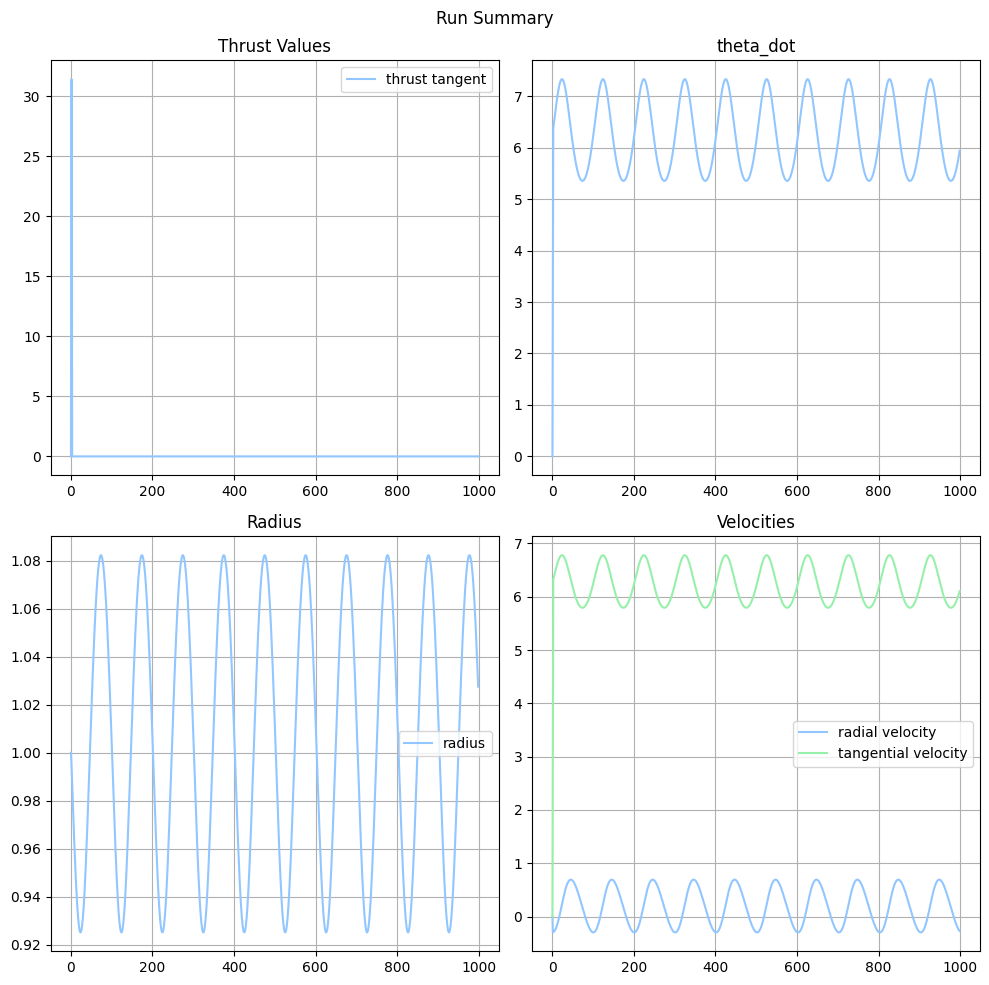

In [19]:
# HAVE AN IMAGE OF THE ENVIRONMENT
# Use of render and show implemented in the environment
env_name = 'RocketCircularization-v1' #walls mechanics off
env3 = make(env_name)
env3 = PolarizeObservation(env3)
env3 = CTangentialThrust(env3)

state = env3.reset()
done = False
i = 1
while not done:
    env3.render()
    if i < 3:
        state, reward, done, truncated, info = env3.step(10*np.pi)
    else:
        state, reward, done, truncated, info = env3.step(0)
    done = done or truncated
    i += 1

env3.show(path='test.mp4')
show_video('test.mp4')



#### Defining the Model

In [20]:
!pip install matplotlib-label-lines

import os
import math
import time
import glob
import random
import numpy as np
import pandas as pd

import gym
from gym import spaces, logger
from gym.utils import seeding
from gym.envs.classic_control import utils
from gym.error import DependencyNotInstalled

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical

from time import sleep
from datetime import datetime
from typing import Optional, Union
from labellines import labelLine, labelLines

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
from IPython.display import HTML

In [21]:
# Memory to storing history of transitions
class ReplayBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


# One model with the Actor *and* Critic networks bundled together
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()
        # Works now for both continuous and discrete action states
        self.has_continuous_action_space = has_continuous_action_space
        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init)

        # Actor
        if has_continuous_action_space :
            # Output range [-1, 1]

            self.actor = nn.Sequential(
                            nn.Linear(state_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, action_dim))
        else:
            # Output discrete n = action_dim actions
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, hidden_dim),
                            nn.ReLU(),
                            nn.Linear(hidden_dim, action_dim),
                            nn.Softmax(dim=-1))

        # Critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, hidden_dim),
                        nn.ReLU(),
                        nn.Linear(hidden_dim, 1))


    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std)
        else:
          print("WARNING : Called ActorCritic::set_action_std() on discrete action space")


    def act(self, state):
        if self.has_continuous_action_space:
            action_mean = self.actor(state) # mean of action predicted by actor
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
             # generate distribution to draw actions from based on learned uncertainty in action
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample() # get action from distribution (adds randomness)
        action_logprob = dist.log_prob(action) # get prob of the action which was drawn for adjusting actor weights
        state_val = self.critic(state) # expected critic network value of state for adjusting critic weights

        return action.detach(), action_logprob.detach(), state_val.detach()


    def evaluate(self, state, action):
        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var)
            dist = MultivariateNormal(action_mean, cov_mat)
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)

        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):
        self.has_continuous_action_space = has_continuous_action_space
        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma # discount of past reward
        self.eps_clip = eps_clip # for clipping values to prevent math issues
        self.epochs = epochs
        self.memory = ReplayBuffer()
        self.policy = ActorCritic(state_dim, action_dim, hidden_dim, has_continuous_action_space, action_std_init)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor, 'betas': (0.99, 0.99)},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic, 'betas': (0.99, 0.99)}
                    ])
        self.policy_old = ActorCritic(state_dim, action_dim, hidden_dim, has_continuous_action_space, action_std_init)
        self.policy_old.load_state_dict(self.policy.state_dict())
        self.MseLoss = nn.MSELoss()


    def set_action_std(self, new_action_std):

        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("WARNING : Called PPO::set_action_std() on discrete action space")


    def decay_action_std(self, action_std_decay_rate, min_action_std):

        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Called PPO::decay_action_std() on discrete action space")


    def select_action(self, state, save):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state)
                action, action_logprob, state_val = self.policy_old.act(state)

            if save:
                self.memory.states.append(state)
                self.memory.actions.append(action)
                self.memory.logprobs.append(action_logprob)
                self.memory.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()

        else:
            with torch.no_grad():
                state = torch.FloatTensor(state)
                action, action_logprob, state_val = self.policy_old.act(state)

            if save:
                self.memory.states.append(state)
                self.memory.actions.append(action)
                self.memory.logprobs.append(action_logprob)
                self.memory.state_values.append(state_val)

            return action.item()


    def update(self):
        # Construct Discounted Sum of Rewards
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.memory.rewards), reversed(self.memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)

        # Normalizing Rewards
        rewards = torch.tensor(rewards, dtype=torch.float32)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # List -> Tensor
        old_states = torch.squeeze(torch.stack(self.memory.states, dim=0)).detach()
        old_actions = torch.squeeze(torch.stack(self.memory.actions, dim=0)).detach()
        old_logprobs = torch.squeeze(torch.stack(self.memory.logprobs, dim=0)).detach()
        old_state_values = torch.squeeze(torch.stack(self.memory.state_values, dim=0)).detach()

        advantages = rewards.detach() - old_state_values.detach()

        for k in range(self.epochs):
            print(f"\rtraining epoch: {k}", end="")

            # Evaluate old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
            state_values = torch.squeeze(state_values)

            # Use PPO conservative weight adjustments
            ratios = torch.exp(logprobs - old_logprobs.detach())
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy

            self.optimizer.zero_grad()
            loss.mean().backward()
            print(f"\t{round(loss.mean().item(), 5)}", end="")
            self.optimizer.step()

        self.policy_old.load_state_dict(self.policy.state_dict())
        self.memory.clear()

    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)

    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

In [22]:
def plot_reward(data, env_string):
    #colors = ['r', 'orange', 'y', 'g', 'c', 'b', 'indigo', 'm', 'grey', 'black']
    colors = ['r', 'y', 'c', 'indigo', 'grey', 'grey', 'indigo', 'c', 'y', 'r']
    labels = ['(0.01, 1)', '(0.1, 1)', '(1, 1)', '(10, 1)', '(100, 1)', '(1, 0.01)', '(1, 0.1)', '(1, 1)', '(1, 10)', '(1, 100)']

    for i in range(len(data)):
        plt.plot(np.arange(len(data[i])), data[i], color=colors[i], label=labels[i])

    plt.xlabel('# Rounds of 10k steps into Training')
    plt.ylabel('Avg Reward calculated every 10k steps')
    plt.title(f'Reward over Training from first varying (Radial, Tick) reward weighting in {env_string} environment')
    plt.grid(True)

    # Add labels to lines
    labelLines(plt.gca().get_lines(), zorder=2.5)

    plt.show()


def plot_rewards_double(data1, data2):
    colors = ['r', 'y', 'c', 'indigo', 'grey', 'grey', 'indigo', 'c', 'y', 'r']
    labels = ['(0.01, 1)', '(0.1, 1)', '(1, 1)', '(10, 1)', '(100, 1)', '(1, 0.01)', '(1, 0.1)', '(1, 1)', '(1, 10)', '(1, 100)']

    plt.figure(figsize=(10, 10))

    for i in range(len(data1)):
        plt.plot(np.arange(len(y[i])), data1[i], color=colors[i], label=labels[i])

    for i in range(len(data2)):
        plt.plot(np.arange(len(data2[i])), data2y2[i], color=colors[i])

    plt.xlabel('# Rounds of 10k steps into Training')
    plt.ylabel('Avg Reward calculated every 10k steps')
    plt.title('Avg Reward over Training from varying (Radial, Tick) reward weighting in 0.9-1.1 environment')
    plt.grid(True)

    # Add labels to lines
    labelLines(plt.gca().get_lines(), zorder=2.5)

    plt.show()

In [23]:
def moving_average(data, window_size):
    """Calculate the moving average of the given list."""
    i = 0
    moving_averages = []
    while i < len(data) - window_size + 1:
        window_average = round(np.sum(data[
          i:i+window_size]) / window_size, 2)
        moving_averages.append(window_average)
        i += 1
    return moving_averages

## Learned Strategy Analysis'

1. Training Curves
2. Decision Boundaries
3. Analytics of One run

0.9-1.1 radial region
- 1000 step max (1 tick, 0.01 radial)
- 2000 step max w reward boosting at 2000 (1 tick, 0.01 radial)


0.2-5.0 radial region
- 1000 step max (1 tick, 0.01 radial)
- 2000 step max w reward boosting at 2000 (1 tick, 0.01 radial)

### 0.9-1.1 radii region

General issues with radius drifting out until death.

##### 1000 step (1 tick, 0.01 radial)

In [ ]:
####### setup #######
has_continuous_action_space = True  # continuous action space; else discrete
max_ep_len = 1_000                  # max timesteps in one episode
max_training_timesteps = 2_500_000  # break training loop if timeteps > max_training_timesteps
print_freq = max_ep_len * 5         # how often (in timesteps) to print avg reward
log_freq = max_ep_len * 5           # how often (in timesteps) to print log avg reward
save_model_freq = max_ep_len * 15   # how often (in timesteps) to save model
update_timestep = max_ep_len        # how often (in timesteps) to update policy

epochs = 80                         # how many (in epochs) to run on updating PPO
eps_clip = 0.2                      # parameter for value clipping

action_std = 0.6                    # starting std for action distribution (Multivariate Normal)
action_std_decay_rate = 0.05        # action_std = action_std - action_std_decay_rate
min_action_std = 0.1                # minimum action_std
action_std_decay_freq = 250_000
                                    # how often (in timesteps) to decay action_std
gamma = 0.99                        # discount factor for considering past summed rewards in value of current state
lr_actor = 5e-4                     # lr for actor
lr_critic = 5e-4                    # lr for critic
hidden_dim = 12                      # hidden layer dimension

random_seed = 0                     # seed (can be set to random number, currently set to 0)

env_name = 'RocketCircularization-v1' # env name to save model under
print("training environment name : " + env_name)

env = make(env_name)
env.max_step = max_ep_len
env.seed()

env = PolarizeObservation(env)
env = CTangentialThrust(env)

state_dim = 3                              # state dimension
action_dim = 1                             # action dimension

####### logging #######
# don't overwrite old log files
log_dir = "PPO_logs"
if not os.path.exists(log_dir):
      os.makedirs(log_dir)
log_dir = log_dir + '/' + env_name + '/'
if not os.path.exists(log_dir):
      os.makedirs(log_dir)

# num of log files in log directory
run_num = 0
current_num_files = next(os.walk(log_dir))[2]
run_num = len(current_num_files)

# new log file for current run
log_f_name = log_dir + '/PPO_' + env_name + "_log_" + str(run_num) + ".csv"
print("current logging run number for " + env_name + " : ", run_num)
print("logging at : " + log_f_name)


####### checkpointing #######
# don't overwrite old weights
run_num_pretrained = 0

directory = "PPO_preTrained"
if not os.path.exists(directory):
      os.makedirs(directory)
directory = directory + '/' + env_name + '/'
if not os.path.exists(directory):
      os.makedirs(directory)

checkpoint_path = directory + "PPO_{}_{}_{}.pth".format(env_name, random_seed, run_num_pretrained)
print("save checkpoint path : " + checkpoint_path)

if random_seed:
    torch.manual_seed(random_seed)
    env.seed(random_seed)
    np.random.seed(random_seed)

####### training procedure #######
ppo_agent = PPO(state_dim, action_dim, hidden_dim, lr_actor, lr_critic, gamma, epochs, eps_clip, has_continuous_action_space, action_std)
start_time = datetime.now().replace(microsecond=0)

print("Started training at (GMT) : ", start_time)
print("============================================================================================")

# log episode, timestep, reward throughout trainking
log_f = open(log_f_name,"w+")
log_f.write('episode,timestep,reward\n')
print_running_reward = 0
print_running_episodes = 0
log_running_reward = 0
log_running_episodes = 0

# training loop

rewards = []

time_step = 0
i_episode = 0
while time_step <= max_training_timesteps:
    state = env.reset()
    env.seed()

    current_ep_reward = 0
    for t in range(1, max_ep_len+1):
        print(f"\rStep: {t} \t [{time_step % print_freq}/{print_freq}]", end="")

        # select action
        env.render()
        action = ppo_agent.select_action(state, True)
        #print(f"{action[0]}")
        state, reward, done, truncated, info = env.step(10*action[0])

        done = done or truncated
        scale_of_thrust = np.linalg.norm(action, ord=1)
        radius = state[0]
        reward = 1 + (0.1 * 1/np.abs(radius - 1)) # Added distance from radius

        # register new step
        ppo_agent.memory.rewards.append(reward)
        ppo_agent.memory.is_terminals.append(done)
        time_step +=1
        #current_ep_reward += reward
        current_ep_reward += 1

        print_avg_reward = print_running_reward / print_running_episodes if print_running_episodes != 0 else 0
        print_avg_reward = round(print_avg_reward, 2)

        # update PPO agent
        if time_step % update_timestep == 0:
            ppo_agent.update()

        # decay action_std when necessary
        if has_continuous_action_space and time_step % action_std_decay_freq == 0:
            ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

        # log in logging file
        if time_step % log_freq == 0:
            log_avg_reward = log_running_reward / log_running_episodes
            log_avg_reward = round(log_avg_reward, 4)
            log_f.write('{},{},{}\n'.format(i_episode, time_step, log_avg_reward))
            log_f.flush()
            log_running_reward = 0
            log_running_episodes = 0

        # print avg reward
        if time_step % print_freq == 0:
            print("\tEpisode : {} \t\t Action Std: {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, ppo_agent.action_std, time_step, print_avg_reward))
            print_running_reward = 0
            print_running_episodes = 0

        # save weights
        if time_step % log_freq == 0 and print_avg_reward == max_ep_len:
            print("--------------------------------------------------------------------------------------------")
            print("saving model at : " + checkpoint_path)
            ppo_agent.save(checkpoint_path)
            time_step = max_training_timesteps
            print("model saved")
            print("Elapsed Time  : ", datetime.now().replace(microsecond=0) - start_time)
            print("--------------------------------------------------------------------------------------------")

        if done:
            if current_ep_reward == max_ep_len:
                current_ep_reward += max_ep_len
            rewards.append(current_ep_reward)
            break

    print_running_reward += current_ep_reward
    print_running_episodes += 1
    log_running_reward += current_ep_reward
    log_running_episodes += 1
    i_episode += 1

log_f.close()
env.close()

# print total training time
print("============================================================================================")
ppo_agent.save("ppo_rocket_circularization")
end_time = datetime.now().replace(microsecond=0)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")

training environment name : RocketCircularization-v1
current logging run number for RocketCircularization-v1 :  0
logging at : PPO_logs/RocketCircularization-v1//PPO_RocketCircularization-v1_log_0.csv
save checkpoint path : PPO_preTrained/RocketCircularization-v1/PPO_RocketCircularization-v1_0_0.pth


/usr/local/lib/python3.10/dist-packages/gym/spaces/box.py:128: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Started training at (GMT) :  2024-07-01 16:14:48
Step: 1 	 [0/5000]

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


training epoch: 79	-0.04673	Episode : 707 		 Action Std: 0.6 		 Timestep : 5000 		 Average Reward : 7.06
training epoch: 79	0.16398	Episode : 1384 		 Action Std: 0.6 		 Timestep : 10000 		 Average Reward : 7.39
training epoch: 79	0.30493	Episode : 1843 		 Action Std: 0.6 		 Timestep : 15000 		 Average Reward : 10.87
training epoch: 79	0.32895	Episode : 2266 		 Action Std: 0.6 		 Timestep : 20000 		 Average Reward : 11.83
training epoch: 79	0.43572	Episode : 2725 		 Action Std: 0.6 		 Timestep : 25000 		 Average Reward : 10.88
training epoch: 79	0.52347	Episode : 3226 		 Action Std: 0.6 		 Timestep : 30000 		 Average Reward : 10.0
training epoch: 79	0.60011	Episode : 3751 		 Action Std: 0.6 		 Timestep : 35000 		 Average Reward : 9.52
training epoch: 79	0.34184	Episode : 4304 		 Action Std: 0.6 		 Timestep : 40000 		 Average Reward : 9.03
training epoch: 79	0.46668	Episode : 4904 		 Action Std: 0.6 		 Timestep : 45000 		 Average Reward : 8.34
training epoch: 79	0.47519	Episode : 5494 		

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


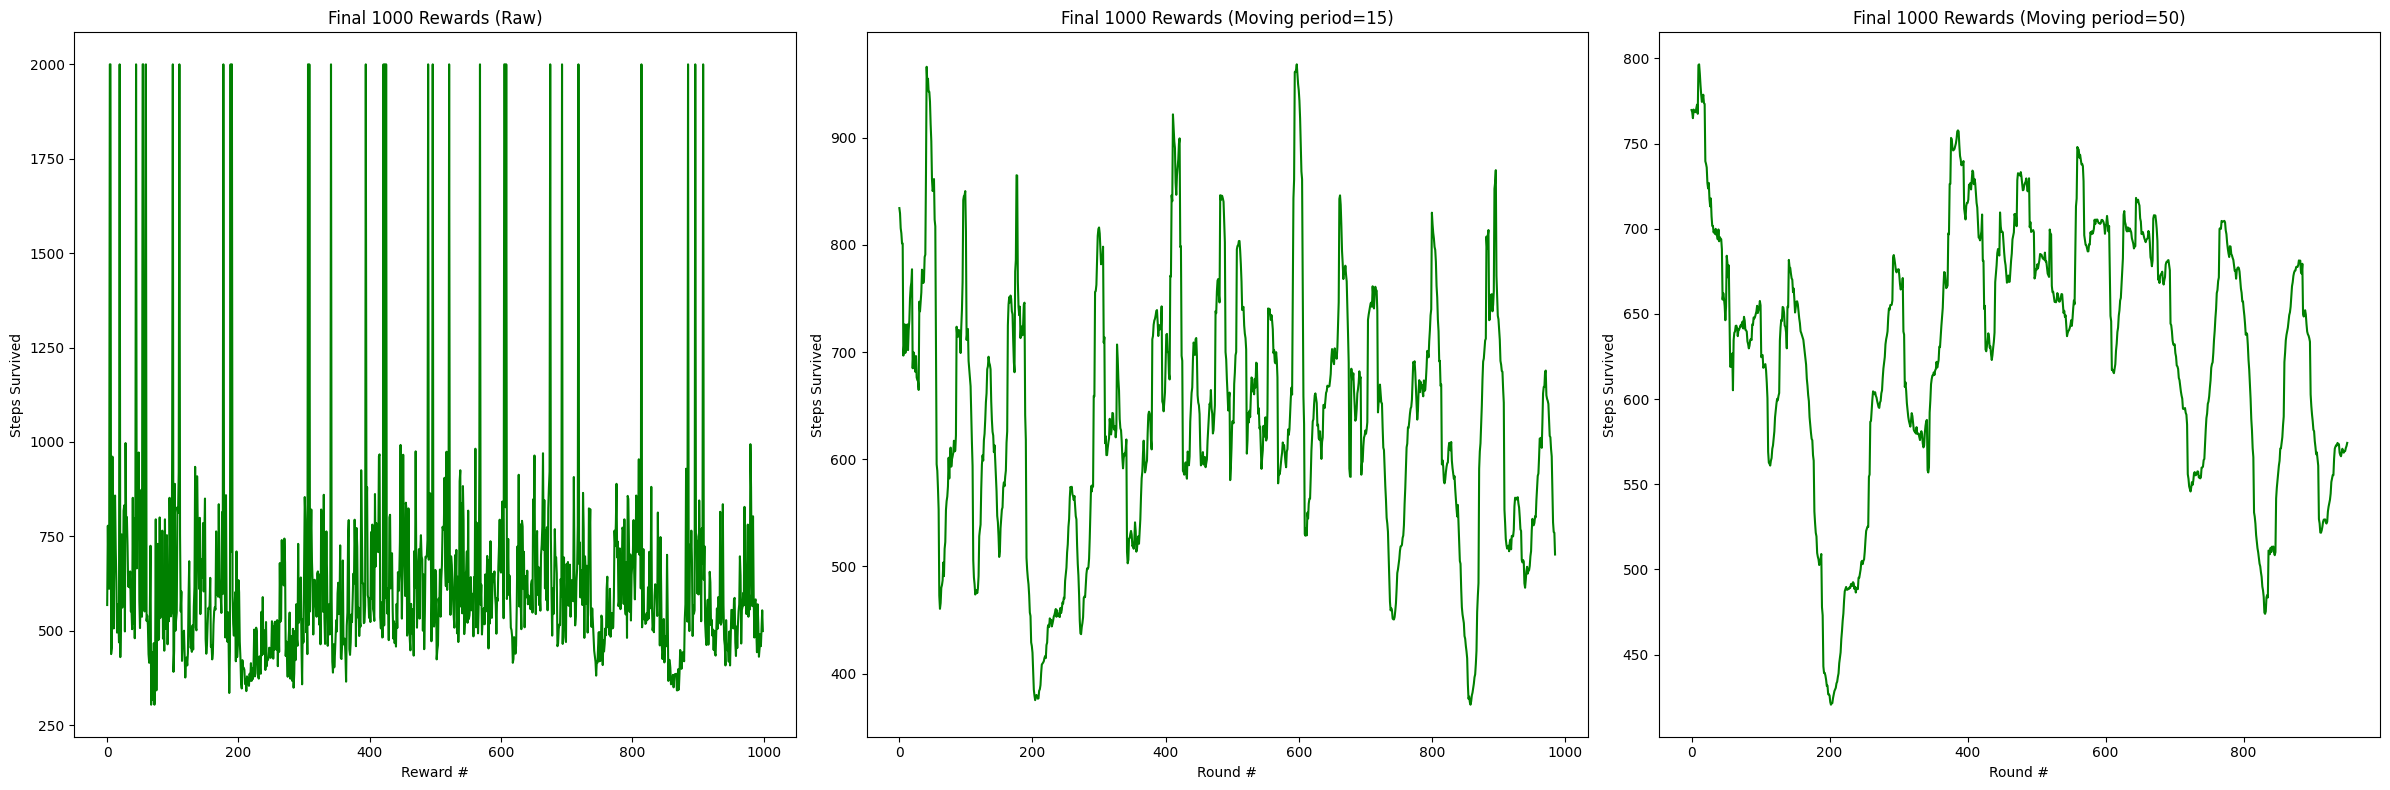

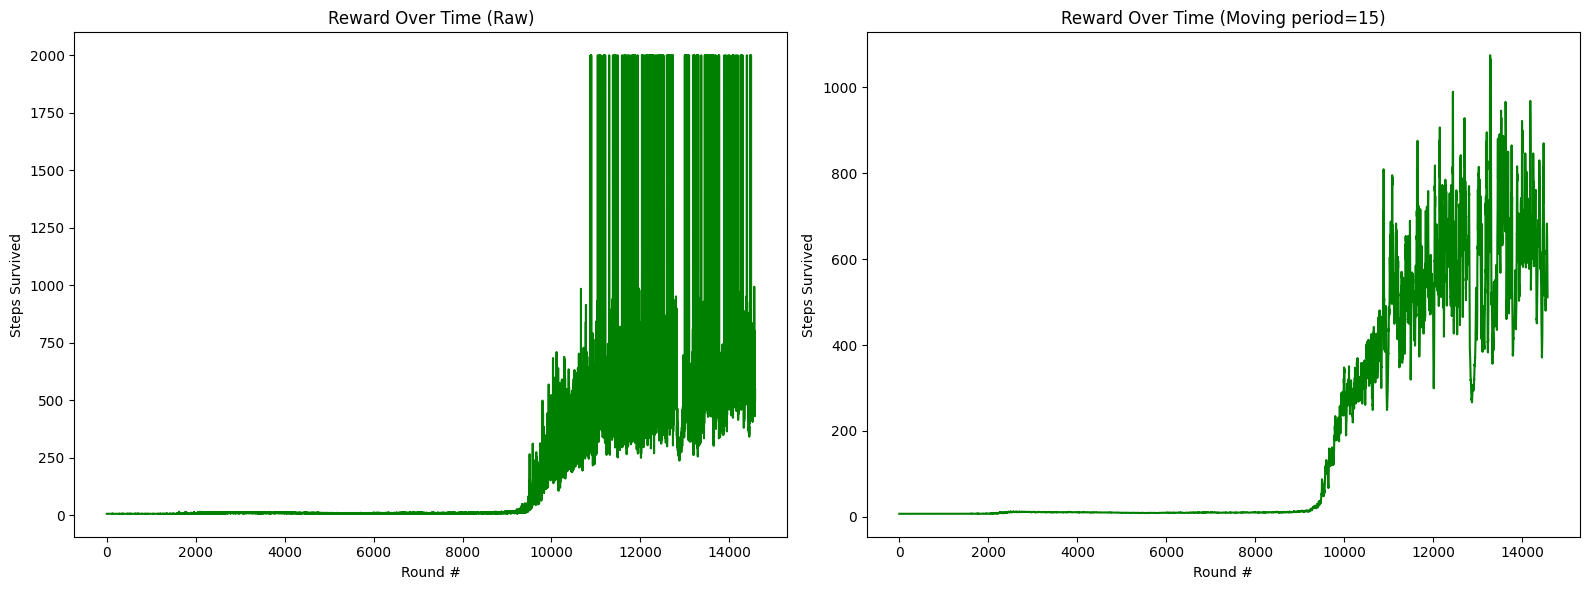

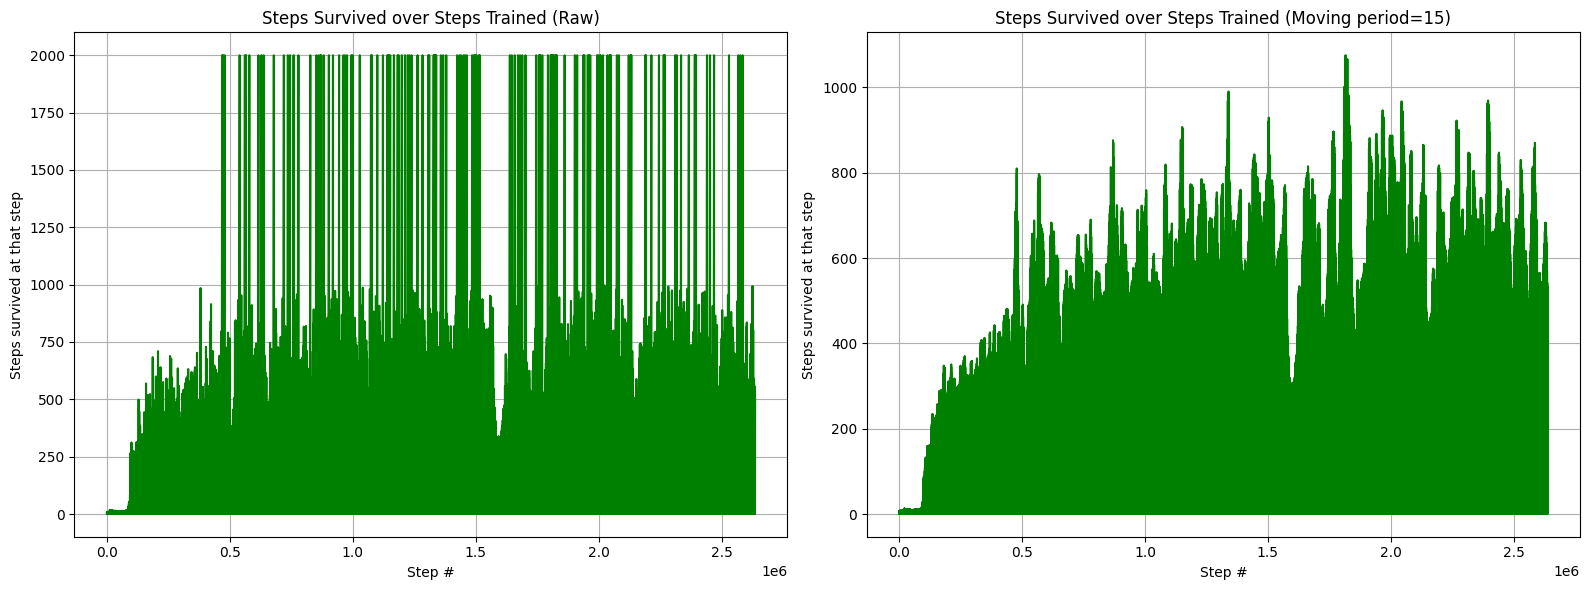

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def moving_average(data, window_size):
    """Calculate the moving average of the given list."""
    i = 0
    moving_averages = []
    while i < len(data) - window_size + 1:
        window_average = round(np.sum(data[
          i:i+window_size]) / window_size, 2)
        moving_averages.append(window_average)
        i += 1
    return moving_averages

# Final 1000 Rewards
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

axs[0].set_title("Final 1000 Rewards (Raw)")
axs[0].set_xlabel("Reward #")
axs[0].set_ylabel("Steps Survived")
axs[0].plot(np.arange(len(rewards[-1000:])), rewards[-1000:], color ="green")

avg_rewards_15 = moving_average(rewards[-1000:], 15)
x = np.arange(0, len(avg_rewards_15))
axs[1].set_title("Final 1000 Rewards (Moving period=15)")
axs[1].set_xlabel("Round #")
axs[1].set_ylabel("Steps Survived")
axs[1].plot(x, avg_rewards_15, color ="green")

avg_rewards_50 = moving_average(rewards[-1000:], 50)
x = np.arange(0, len(avg_rewards_50))
axs[2].set_title("Final 1000 Rewards (Moving period=50)")
axs[2].set_xlabel("Round #")
axs[2].set_ylabel("Steps Survived")
axs[2].plot(x, avg_rewards_50, color ="green")

plt.tight_layout()
plt.show()

# Reward Over Time
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

axs[0].set_title("Reward Over Time (Raw)")
axs[0].set_xlabel("Round #")
axs[0].set_ylabel("Steps Survived")
axs[0].plot(np.arange(len(rewards)), rewards, color ="green")

avg_rewards_time = moving_average(rewards, 15)
x = np.arange(0, len(avg_rewards_time))
axs[1].set_title("Reward Over Time (Moving period=15)")
axs[1].set_xlabel("Round #")
axs[1].set_ylabel("Steps Survived")
axs[1].plot(x, avg_rewards_time, color ="green")

plt.tight_layout()
plt.show()


# Step-like plots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

y_values_raw = sum([list(np.arange(1, val+1)) for val in rewards], [])
axs[0].plot(np.arange(len(y_values_raw)), y_values_raw, color ="green")
axs[0].set_xlabel('Step #')
axs[0].set_ylabel('Steps survived at that step')
axs[0].set_title('Steps Survived over Steps Trained (Raw)')
axs[0].grid(True)

y_values_ma = sum([list(np.arange(1, val+1)) for val in avg_rewards_time], [])
axs[1].plot(np.arange(len(y_values_ma)), y_values_ma, color ="green")
axs[1].set_xlabel('Step #')
axs[1].set_ylabel('Steps survived at that step')
axs[1].set_title('Steps Survived over Steps Trained (Moving period=15)')
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Function to evaluate model across a grid of states
def evaluate_action_grid(model, grid_size=50, state_dims=(0, 2)):
    x = np.linspace(-1, 1, grid_size)
    y = np.linspace(-1, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    # Select the third index to set as zero based on unused dimension
    zero_idx = 3 - sum(state_dims)  # sum of indices 0, 1, 2 is 3, so this gives the remaining one

    for i in range(grid_size):
        for j in range(grid_size):
            obs = np.zeros(3)
            obs[state_dims[0]] = X[i, j]
            obs[state_dims[1]] = Y[i, j]
            action = model.select_action(obs, True)
            Z[i, j] = action[0]

    return X, Y, Z

# Generate action grid
X02, Y02, action_grid02 = evaluate_action_grid(ppo_agent, state_dims=(0, 2))
X01, Y01, action_grid01 = evaluate_action_grid(ppo_agent, state_dims=(0, 1))
X12, Y12, action_grid12 = evaluate_action_grid(ppo_agent, state_dims=(1, 2))

# Plotting
plt.figure(figsize=(15, 10))

# State[0] vs State[2] (original)
plt.subplot(1, 3, 1)
contour = plt.contourf(X02, Y02, action_grid02.squeeze(), cmap='viridis')
plt.colorbar(contour)
plt.xlabel('Radius')
plt.ylabel('Tangential Velocity')
plt.title('Action vs. Radius & Tangential Velocity')

# State[0] vs State[1]
plt.subplot(1, 3, 2)
contour = plt.contourf(X01, Y01, action_grid01.squeeze(), cmap='viridis')
plt.colorbar(contour)
plt.xlabel('Radius')
plt.ylabel('Radial Velocity')
plt.title('Action vs. Radius & Radial Velocity')

# State[1] vs State[2]
plt.subplot(1, 3, 3)
contour = plt.contourf(X12, Y12, action_grid12.squeeze(), cmap='viridis')
plt.colorbar(contour)
plt.xlabel('Radial Velocity')
plt.ylabel('Tangential Velocity')
plt.title('Action vs. Radial & Tangential Velocity')

plt.tight_layout()
plt.show()

It is creating a figure 1 


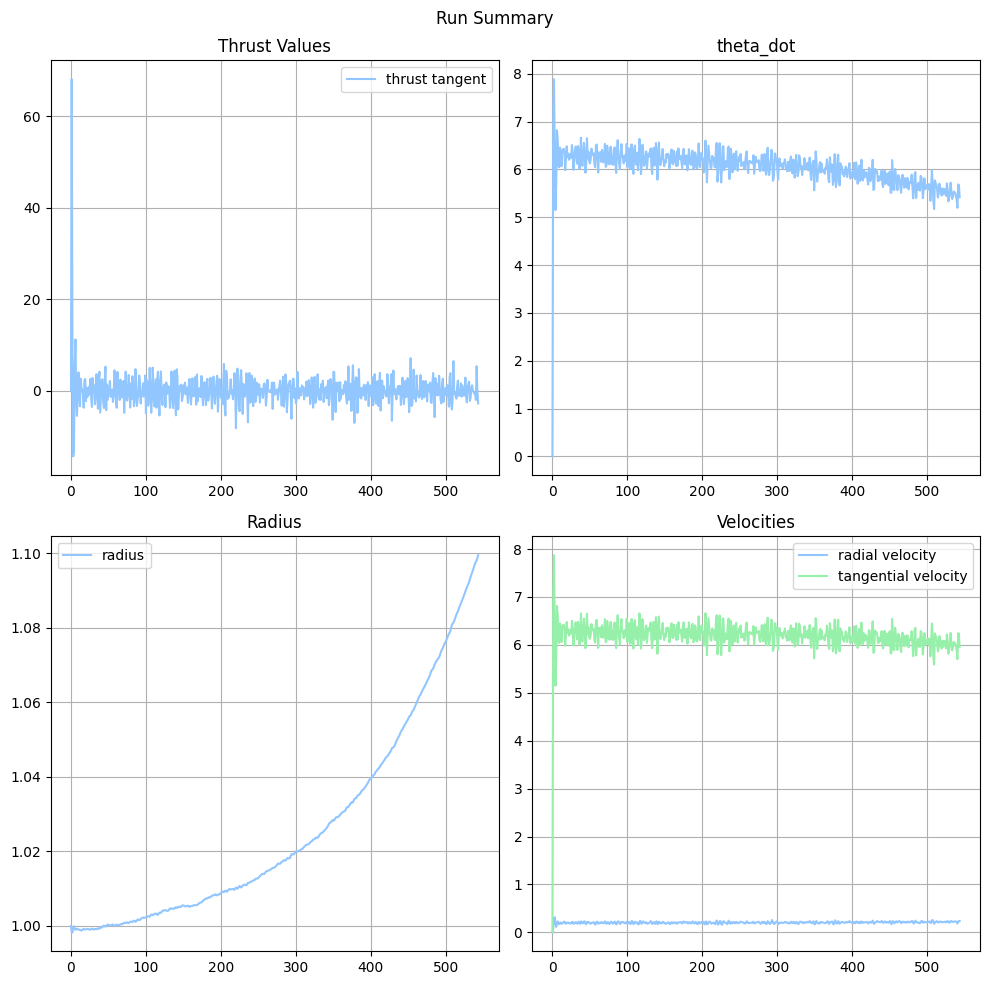

In [ ]:
state = env.reset()
done = False
while not done:
    env.render()
    action = ppo_agent.select_action(state, True)
    state, reward, done, truncated, info = env.step(10*action[0])
    done = done or truncated

env.show(path='test.mp4')
show_video('test.mp4')